
Based on NLP From Scratch: Generating Names with a Character-Level RNN
*************************************************************
by: `Sean Robertson <https://github.com/spro/practical-pytorch>`_


In [68]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
from random import shuffle
import torch
import torch.nn as nn
from functools import reduce
from collections import Counter
import re
import numpy as np
%matplotlib inline

In [69]:


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bias=True, batch_first=False,
                dropout=0, bidirectional=False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, bias=bias, batch_first=batch_first,
                           dropout=dropout, bidirectional=bidirectional)
#         self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)

        self.o2o = nn.Linear(self.num_directions * hidden_size, output_size)
#         self.dropout = nn.Dropout(0.1)
#         self.softmax = nn.Softmax(dim=2)

    def forward(self, my_input, hidden):
#         input_combined = torch.cat((category, input, hidden), 1)
#         hidden = self.i2h(input_combined)
#         output = self.i2o(input_combined)
#         output_combined = torch.cat((hidden, output), 1)
#         output = self.o2o(output_combined)
#         output = self.dropout(output)
        output, hidden = self.lstm(my_input, hidden)
        output = self.o2o(output)
#         output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch=1, device=torch.device('cpu')):
        return (torch.zeros(self.num_layers,1,self.hidden_size, device=device), torch.zeros(self.num_layers * self.num_directions,batch,self.hidden_size,device=device))
#         return torch.zeros(1, self.hidden_size)

In [70]:

def string_to_chars(original):
    raw_lines = original.splitlines()

    def proc_line(l): return [l] if l == '<start>' or l == '<end>' else list(l)
    chars = reduce(lambda x, y : x + ['\n'] + y, list(map(proc_line, raw_lines)))
    assert original == ''.join(chars)
    return chars

def make_encoder(raw):
    chars = string_to_chars(raw)
    decoder = [c for c in Counter(chars)]
    decoder = sorted(decoder)
    return {c:i for i, c in enumerate(decoder)}, decoder

def split_songs(raw):
    return re.findall('(<start>.*?<end>)',raw,flags=re.DOTALL)

# train_songs = list(map(string_to_chars, split_songs(raw_train)))

# reconstructed = '\n'.join(map(''.join, train_songs))
# encoder, decoder = make_encoder(raw_train)
# n_chars = len(decoder)

def song_to_tensor_chunks(song,encoder, decoder):
    training_chunks = []
    target_chunks = []
    for i in range(0,len(song),100):
        start = i
        if start+100 > len(song) - 1:
            end = len(song)
            target_range = list(np.arange(start + 1, end,dtype=np.int)) + [int(end - 1)]
        else:
            end = start + 100
            target_range = np.arange(start+1, end+1, dtype=np.int)
        chunk = torch.zeros(end-start, 1, n_chars)
        for i, c in enumerate(song[start:end]):
            chunk[i,0,encoder[c]] = 1
        target_chunk = []
        for i in target_range:
            target_chunk.append(encoder[song[i]])
        target_chunks.append(torch.tensor(target_chunk))
        training_chunks.append(chunk)
    return training_chunks, target_chunks


In [71]:
raw_train = open('train.txt').read()
train_songs = list(map(string_to_chars, split_songs(raw_train)))

reconstructed = '\n'.join(map(''.join, train_songs))
encoder, decoder = make_encoder(raw_train)
n_chars = len(decoder)
val_songs = list(map(string_to_chars, split_songs(open('val.txt').read())))
test_songs = list(map(string_to_chars, split_songs(open('test.txt').read())))
assert reconstructed == raw_train


For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [72]:
criterion = nn.CrossEntropyLoss()

def train(song,optimizer=None, device=torch.device('cpu')):
    train_chunks, target_chunks = song_to_tensor_chunks(song, encoder,decoder)
    hidden = rnn.initHidden(device=device)
    rnn.zero_grad()

    loss = 0

    for input_line_tensor, target_line_tensor in zip(train_chunks,target_chunks):
        target_line_tensor.unsqueeze_(-1)
        for i in range(input_line_tensor.size(0)):
            output, hidden = rnn(input_line_tensor[i].view((1,1,n_chars)).to(device), hidden)
    #         print(output)
            l = criterion(output.view((1,n_chars)), target_line_tensor[i].to(device))
            loss += l / input_line_tensor.size(0)

    loss.backward()
    optimizer.step()

    return output, loss.item() / len(train_chunks)
def test(rnn, song, device=torch.device('cpu')):
    train_chunks, target_chunks = song_to_tensor_chunks(song, encoder,decoder)
    hidden = rnn.initHidden(device=device)
    loss = 0
    for input_line_tensor, target_line_tensor in zip(train_chunks,target_chunks):
        target_line_tensor.unsqueeze_(-1)
        output, hidden = rnn(input_line_tensor.to(device), hidden)
        seq_len,_ =target_line_tensor.size()
        l = criterion(output.view((seq_len,n_chars)), target_line_tensor.view((seq_len)).to(device))
        loss += l
    return output, loss.item() / len(train_chunks)

In [73]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [74]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [75]:
rnn = RNN(n_chars, 100, n_chars).to(device) #hidden_size originally 128
#rnn.load_state_dict(torch.load('rnn_1574760411.pt'))
rnn = rnn.to(device)
#train_loss = list(map(float,(open('train_loss_1574760411.csv').read().splitlines())))
#val_loss = list(map(float,(open('val_loss_1574760411.csv').read().splitlines())))
#print(len(train_loss))
#start = len(train_loss)

optimizer = torch.optim.Adam(rnn.parameters())

In [78]:
# rnn = RNN(n_chars, 128, n_chars).to(device)
learning_rate = 0.05
# optimizer = torch.optim.Adam(rnn.parameters())
n_iters = 10000
print_every = 80
plot_every = 10
train_loss = []
val_loss = []
total_loss = 0 # Reset every plot_every iters
n_epochs = 20
start = time.time()

for epoch in range(int(start),int(start+n_epochs)):
    shuffle(train_songs)
    total_loss = 0
    for i, song in enumerate(train_songs):
        output, loss = train(song,optimizer=optimizer, device=device)
        total_loss += loss
        if i % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), i, i / len(train_songs) * 100, loss))


    train_loss.append(total_loss / len(train_songs))
    with torch.no_grad():
        total_loss = 0
        for song in test_songs:
            _, loss = test(rnn, song, device=device)
            total_loss += loss
        val_loss.append(total_loss / len(test_songs))
    torch.save(rnn.state_dict(),f'rnn_{epoch}.pt')
    with open(f'train_loss_{epoch}.csv', 'w+') as out:
        out.write('\n'.join(map(str,train_loss)))

    with open(f'val_loss_{epoch}.csv', 'w+') as out:
        out.write('\n'.join(map(str,val_loss)))
    print('Epoch %d %s val loss: %.4f train loss: %.4f\n' % (epoch,timeSince(start), val_loss[-1], train_loss[-1]))   
        

0m 0s (0 0%) 2.7532
0m 46s (80 9%) 2.7193
1m 36s (160 19%) 2.2925
2m 27s (240 29%) 3.3124
3m 13s (320 39%) 2.5487
4m 6s (400 49%) 2.6033
4m 58s (480 59%) 3.1760
5m 49s (560 69%) 2.5699
6m 48s (640 79%) 2.3490
7m 39s (720 89%) 2.6861
8m 29s (800 99%) 2.5357
Epoch 1574860735 8m 34s val loss: 2.2785 train loss: 2.5367

8m 34s (0 0%) 2.4826
9m 30s (80 9%) 2.3223
10m 24s (160 19%) 2.4637
11m 16s (240 29%) 1.9669
12m 8s (320 39%) 1.8576
13m 1s (400 49%) 2.4203
13m 46s (480 59%) 2.1977
14m 31s (560 69%) 1.5729
15m 20s (640 79%) 2.2863
16m 11s (720 89%) 2.4051
17m 2s (800 99%) 2.1248
Epoch 1574860736 17m 7s val loss: 2.1230 train loss: 2.1909

17m 7s (0 0%) 2.3153
17m 54s (80 9%) 2.0813
18m 49s (160 19%) 2.6668
19m 35s (240 29%) 1.9436
20m 26s (320 39%) 2.4508
21m 17s (400 49%) 2.1246
22m 7s (480 59%) 1.9143
23m 2s (560 69%) 1.7308
23m 48s (640 79%) 1.6070
24m 37s (720 89%) 1.0877
25m 36s (800 99%) 2.0857
Epoch 1574860737 25m 40s val loss: 1.9795 train loss: 1.9923

25m 40s (0 0%) 2.1496
26m 2

[2.5367129308997427, 2.190908712812478, 1.9923137943961395, 1.846779023665649, 1.7452958142785664, 1.6638741107951065, 1.600470591454109, 1.546412259929671, 1.5034050571506863, 1.4745895855487376, 1.4320434205136054, 1.406719924045259, 1.3842393386963041, 1.3576616240824781, 1.3408265668992454, 1.3196220277680806, 1.3022022568206173, 1.2888662287889237, 1.2707248890103247, 1.2603410774352026]
[2.2785263149579507, 2.122958825581485, 1.9795486480272244, 1.9024232473531768, 1.769352910131801, 1.7786977130739874, 1.7033790068161916, 1.6820820049526435, 1.6753724007873156, 1.6399661394319145, 1.6139073459195927, 1.589667223520683, 1.5784670147419029, 1.582696457402064, 1.579413537628565, 1.561722125328431, 1.5418219784571194, 1.5581586753418462, 1.5447819750654515, 1.5535016826768067]


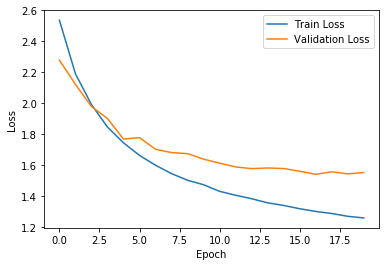

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
offset = 0
epoch_nums = [i for i in range(len(train_loss)+1)]
print(train_loss)
print(val_loss)
with open('train_loss_{offset}.csv', 'w+') as out:
    out.write('\n'.join(map(str,train_loss)))

with open('val_loss_{offset}.csv', 'w+') as out:
    out.write('\n'.join(map(str,val_loss)))
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [43]:
# Generates song using temperature of samples
def sample_temp(temperature = 0.8):
    with torch.no_grad():
        input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
        input_tensor = input_tensor_chunk[0].to(device)
        hidden = rnn.initHidden(device=device)
        prev_char_raw, hidden = rnn(input_tensor,hidden) 
        prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        output = '<start>'
        while True:
            output_dist = prev_char_raw.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            selected_char = decoder[top_i.item()]
            output += selected_char
            input_tensor_chunk, _ = song_to_tensor_chunks([selected_char], encoder, decoder)
            input_tensor = input_tensor_chunk[0].to(device)
            # End song 
            if selected_char == '<end>':
                break
            # Get next letter 
            else:
                prev_char_raw, hidden = rnn(input_tensor,hidden) 
                prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        return output
print(sample_temp())

tensor([4.2465e-08, 9.9973e-01, 2.0727e-05, 1.6488e-07, 4.9838e-07, 1.8923e-07,
        3.4205e-08, 4.0373e-07, 1.0571e-06, 1.5788e-06, 3.0465e-08, 7.2443e-08,
        2.2444e-06, 2.5675e-06, 2.0363e-06, 4.0226e-07, 2.0947e-05, 1.0290e-04,
        2.2070e-06, 5.8563e-07, 9.4304e-07, 2.6823e-05, 1.3309e-05, 6.8630e-06,
        8.9454e-07, 7.3722e-06, 3.9822e-06, 3.8618e-08, 3.1200e-09, 7.5412e-10,
        3.4363e-07, 2.0964e-07, 8.2835e-07, 9.2270e-08, 1.6127e-07, 8.0383e-07,
        4.3177e-07, 9.8455e-07, 4.7658e-07, 3.8624e-07, 6.8874e-07, 7.2042e-08,
        4.1709e-07, 1.2190e-07, 1.3115e-07, 1.2197e-07, 3.2569e-07, 1.0048e-08,
        7.4366e-09, 1.0547e-07, 4.2875e-08, 1.1428e-08, 2.8098e-08, 2.2973e-07,
        4.1117e-08, 5.3874e-08, 2.8445e-08, 8.9403e-06, 2.0076e-08, 1.8460e-08,
        1.5638e-06, 2.1176e-06, 2.6705e-05, 7.4391e-08, 1.6207e-07, 1.4134e-07,
        4.6817e-07, 1.3973e-07, 1.9878e-08, 8.7426e-08, 8.5638e-08, 6.0738e-08,
        7.9807e-08, 1.5996e-07, 9.4598e-

In [67]:
def sample_max(max_length = 1000):
    with torch.no_grad():
        counter = 0
        input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
        input_tensor = input_tensor_chunk[0].to(device)
        hidden = rnn.initHidden(device=device)
        prev_char_raw, hidden = rnn(input_tensor,hidden) 
        output = '<start>'
        maxarg = torch.argmax(prev_char_raw)
        while True:
            selected_char = decoder[maxarg.item()]
            print('selected_char', selected_char)
            output += selected_char
            input_tensor_chunk, _ = song_to_tensor_chunks([selected_char], encoder, decoder)
            input_tensor = input_tensor_chunk[0].to(device)
            # End of song
            if selected_char == '<end>':
                break
            # Song is repeating and wont end
            if counter == max_length:
                output += '<end>'
                break
            else:
                prev_char_raw, hidden = rnn(input_tensor,hidden) 
                maxarg = torch.argmax(prev_char_raw)
            counter += 1
        return output
print(sample_max())

selected_char 

selected_char X
selected_char :
selected_char 1
selected_char 

selected_char T
selected_char :
selected_char B
selected_char o
selected_char u
selected_char r
selected_char  
selected_char t
selected_char h
selected_char e
selected_char  
selected_char o
selected_char b
selected_char s
selected_char e
selected_char  
selected_char t
selected_char h
selected_char e
selected_char  
selected_char C
selected_char o
selected_char u
selected_char r
selected_char n
selected_char e
selected_char  
selected_char T
selected_char h
selected_char e
selected_char 

selected_char R
selected_char :
selected_char h
selected_char o
selected_char r
selected_char n
selected_char p
selected_char i
selected_char p
selected_char e
selected_char 

selected_char C
selected_char :
selected_char T
selected_char r
selected_char a
selected_char d
selected_char .
selected_char 

selected_char Z
selected_char :
selected_char T
selected_char r
selected_char a
selected_char n
selected_char s
selected

In [42]:
# Normal run 20 epochs
for i in range(6):
    print(sample())

tensor([4.2465e-08, 9.9973e-01, 2.0727e-05, 1.6488e-07, 4.9838e-07, 1.8923e-07,
        3.4205e-08, 4.0373e-07, 1.0571e-06, 1.5788e-06, 3.0465e-08, 7.2443e-08,
        2.2444e-06, 2.5675e-06, 2.0363e-06, 4.0226e-07, 2.0947e-05, 1.0290e-04,
        2.2070e-06, 5.8563e-07, 9.4304e-07, 2.6823e-05, 1.3309e-05, 6.8630e-06,
        8.9454e-07, 7.3722e-06, 3.9822e-06, 3.8618e-08, 3.1200e-09, 7.5412e-10,
        3.4363e-07, 2.0964e-07, 8.2835e-07, 9.2270e-08, 1.6127e-07, 8.0383e-07,
        4.3177e-07, 9.8455e-07, 4.7658e-07, 3.8624e-07, 6.8874e-07, 7.2042e-08,
        4.1709e-07, 1.2190e-07, 1.3115e-07, 1.2197e-07, 3.2569e-07, 1.0048e-08,
        7.4366e-09, 1.0547e-07, 4.2875e-08, 1.1428e-08, 2.8098e-08, 2.2973e-07,
        4.1117e-08, 5.3874e-08, 2.8445e-08, 8.9403e-06, 2.0076e-08, 1.8460e-08,
        1.5638e-06, 2.1176e-06, 2.6705e-05, 7.4391e-08, 1.6207e-07, 1.4134e-07,
        4.6817e-07, 1.3973e-07, 1.9878e-08, 8.7426e-08, 8.5638e-08, 6.0738e-08,
        7.9807e-08, 1.5996e-07, 9.4598e-

<start>
X:5
T:Ferrolan's Connan's ETNian Reandhe
R:hornpipe
H:de bouth sastathersB
Z:id:hn-jig-24
M:2/4
K:D
L:1/8
K:F
(G2) A>A Bd B>d | e2f f>g d>d c>A de f>e ge | e2c d2 f>d ec de fg gag dd e2 df d>d eg | e2d gf/e/ e/d/e/d/ d>ded | c/ d/e/e/g/ ede | f/e/ e/c/c/d/ e/f/g/f/e/ b/ag/g/ ed c2 de | dg e>d ce BA AB/B/ G|: G/E/E/ A/G/G/ A/ B/A/B/G/ | AB BG | AG FA A>^c d>c Bc cA/A/A/ | ed/c/B/d/ Bc B/B/B/d/ | fe f>f d>c dc dD Bd | dc d/B/ AB/c/ | d2 cd eg/f/ | d3 ec/2c/B/ d/e/2 dB/c/ (3d//B/ e/d/ e/f/g/ ed ef dc de/d/ d/f/g/ d/B/G/B/ Ac (B/A/B/G/B/A/ B/A/F/B/G | AG Gz BA :|
<end>


In [14]:
# hidden size 64 run 16 epochs
for i in range(6):
    print(sample())

<start>
X:60
T:Framdo dercioner's(
R:Scyledhe Heral S:C. (are.z.
R:Scolka Ginthe
Z:id:hn-polka-31
M:2/4
L:1/12
K:G
~G/e/ gG |
<end>
<start>
X:9
T:Lorow Roeutin, The
R:jig
L:1/8
O:Frave
C:hnDne-020
K:GB|
P:Finlendouto! d fff e2g | cdf d2 c3 | c>d cB c2 :| BF/B/c/B/ AB/e/ fe/f/f | f4 ga | e3 fc d dB Bdd/2 e/d/f/ gf e/d/d/e/ df ef gf f>f ed dc cA FF GA BBA AG | (G/c/B/d/ B/B/ BB |f/g/ eB g/e/c/e/ Bd/e/ ed gg | eg f>f fe | f>d ed de dd | de dc dB | de fe ee>f | g3 eb/c/ d/d>cB | B>G E>B A>B A| cd de ga f>e fe d>d g>e c | d2 gd/e/d/A/ GB cf B>d ce d>c>e ff>f f>d ff eg fg e>df G2 d>d | e2e fd/f/>d/2 g3 d>c A>Bc dc cB AB Bd c>ec | c/d/ d/e//e/d/A/ d>B AB BA | A2 AF BA F2 :|
<end>
<start>
X:15
T:Pour lourif's
N:Cialle
O:France
C:Trag.
E:Prougic.
C:La gfithor pary ig
Z:id:hn-march-31
M:2/4
L:1/8
H:Aristtion: O, 98L
D:wolliche -riesetalyu ttgan:
Z:A/argale
M:2/4
|:26
|: c/c/d/f/g/ d/B/ Bd df | ge/f/e/ d2 d | cd/c/ G2 B/2e/2 | B2z E>B/2G/ | E3/2G/4A/2 B3/4/2:| 
|:B2B/2 d/^2 dc/2c/2 :e2A2 GF AA>z 

In [84]:
# 20 epochs temp = 1 hidden size = 100
for i in range(6):
    print(sample_temp(.8))

tensor([2.9084e-09, 9.9997e-01, 1.0529e-05, 3.9355e-08, 1.5052e-07, 5.1408e-10,
        3.3442e-09, 5.0475e-08, 9.7168e-08, 9.2253e-09, 4.5500e-10, 8.3911e-09,
        4.8562e-07, 1.2648e-08, 4.5045e-07, 3.2111e-09, 1.0331e-07, 6.2247e-06,
        1.8196e-07, 1.8649e-08, 4.3835e-07, 4.9637e-07, 4.7228e-07, 1.7435e-07,
        5.0909e-07, 7.5906e-07, 1.0901e-07, 3.6295e-08, 7.2696e-09, 9.2940e-12,
        3.3755e-07, 2.2273e-08, 6.0272e-08, 2.8122e-09, 1.4623e-07, 1.5425e-07,
        5.5459e-09, 9.4314e-09, 3.5355e-08, 2.6348e-08, 7.6767e-08, 4.4816e-09,
        2.7062e-08, 3.4132e-09, 1.0947e-08, 9.5221e-08, 1.5102e-08, 3.7160e-10,
        8.4222e-11, 4.4198e-08, 6.7730e-09, 6.4547e-10, 1.2991e-09, 6.0820e-08,
        3.4903e-09, 7.3880e-09, 4.0547e-10, 4.3850e-07, 4.4675e-10, 1.3480e-09,
        8.7375e-07, 7.1143e-07, 3.7942e-07, 7.8190e-09, 1.7729e-08, 3.1790e-08,
        1.2851e-08, 1.0402e-07, 5.2180e-07, 2.1799e-07, 1.8601e-08, 4.1301e-09,
        5.2067e-10, 5.0714e-09, 4.9963e-

<start>
X:71
T:Lisa mampe, The
R:hornpipe
D:Mith Frankaig
N:machtec Altou:
O:France
C:Randy Harland <dachesci.frfe.
O:France
A:Provence
C:Trad.
R:Ronande
H:Scoull played in F7
Z:aighneesetttuprar Micillle du harbee 
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-06-12
Z:Pour toute observation mailto:galouvielle@free.fr
M:3/4
Q:3/8Qb3/2 f/2g/2c/2B/2 | c/2c/2 B/2c/2 g/2e/2 | c/2c/2 B/2A/2 A/2G/2 | G/2G/2G/2A/2 EG|A/2A/2 A/2A/2-A/2G/2 | B/2d/4 A2 :|
<end>
